<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
# Initial Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/TDTU/voice-processing/audio.zip" -d "/content"

Archive:  /content/drive/MyDrive/TDTU/voice-processing/audio.zip
   creating: /content/audio/
  inflating: /content/audio/door.wav  
  inflating: /content/audio/forest.wav  
  inflating: /content/audio/jackhammer.wav  
  inflating: /content/audio/message.wav  
  inflating: /content/audio/mixed_signal.wav  
  inflating: /content/audio/silence.wav  
  inflating: /content/audio/speech.wav  


<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
# Utility Functions Definition

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal import resample, butter, lfilter, spectrogram
import IPython.display as ipd
import numpy as np
from scipy.fft import fft
from scipy.signal.windows import hamming

In [ ]:
def read_and_resample(file1: str, file2: str) -> tuple[np.ndarray, np.ndarray, int]:
    """
    Read two audio files and resample the second one to the sampling rate of the first one.

    Parameters
    ----------
    file1: str
        Path to the first audio file.
    file2: str
        Path to the second audio file.

    Returns
    -------
    audioSignal1: numpy.array
        Audio signal of the first file.
    audioSignal2: numpy.array
        Audio signal of the second file resampled to the sampling rate of the first file.
    fs1: int
        Sampling rate of the first file.
    """
    audioSignal1, fs1 = librosa.load(file1, sr=None)
    audioSignal2, fs2 = librosa.load(file2, sr=None)

    if fs1 != fs2:
        audioSignal2 = resample(audioSignal2, int(len(audioSignal2) * fs1 / fs2))

    return audioSignal1, audioSignal2, fs1

In [ ]:
def normalize(signal: np.ndarray) -> np.ndarray:
    """
    Normalize the input signal to the fixed range [-1, 1].

    Parameters
    ----------
    signal: numpy.array
        Input signal.

    Returns
    -------
    numpy.array
        Normalized signal.
    """
    return signal / np.max(np.abs(signal))

In [ ]:
def np_energy_sad(signal: np.ndarray, fs: int, win: float, thresh: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Detect speech regions in the input signal based on the energy of the signal.

    Parameters
    ----------
    signal: numpy.array
        Input signal array to be processed.
    fs: int
        Sampling frequency of the input signal.
    win: float
        Window size in seconds for calculating the energy.
    thresh: int
        Energy threshold for detecting speech.

    Returns
    -------
    detected_speech: numpy.array
        Binary array indicating the detected speech regions.
    energy: numpy.array
        Energy of the signal in each frame.
    snr: numpy.array
        Signal-to-noise ratio in dB in each frame.
    """
   # Apply a bandpass filter to signal to reduce ambient noise and fp
    fpass = [300, 1500]  # Passband frequencies in Hz
    b, a = butter(4, [f/(fs/2) for f in fpass], btype='band')
    signal = lfilter(b, a, signal)

    frame_size = round((win * 1e-3) * fs)
    signal[:fs] = 0
    signal[-fs:] = 0
    length = len(signal)
    voice_bin_len = int(np.ceil(length / frame_size))
    voice_bin = np.zeros(voice_bin_len, dtype=int)
    snr = np.zeros(voice_bin_len)
    count = 0

    for i in range(0, length, frame_size):
        edge = (frame_size + i) - 1
        if edge >= length:
            edge = length - 1
        frame = signal[i:edge+1]
        ts = 1 / fs
        Lfft = 1024
        freq_axis = np.arange(0, Lfft // 2) / (Lfft * ts)
        frame_size = max(1, round((win * 1e-3) * fs))
        S = fft(frame.astype(float), frame_size)
        S = S[:len(S)//2]

        # Remove frequencies outside the range [195 Hz, 3843 Hz]
        begin_index = np.argmax(freq_axis >= 195)
        end_index = np.argmax(freq_axis >= 3843)
        S[:begin_index] = 0.0
        S[end_index:] = 0.0
        S = np.abs(S)
        S_squared = S ** 2
        Et = np.sum(S_squared)

        S_sorted = np.sort(S_squared)
        idx_start = round(0.10 * len(S_sorted))
        idx_end = round(0.20 * len(S_sorted))
        Np = (1 / 100.0) * np.sum(S_sorted[idx_start:idx_end]) + 1e-5
        L = 1
        upper_idx = len(S_sorted)

        # Dynamically determine the upper index
        for j in range(upper_idx - 1, -1, -1):
            if np.sum(S_sorted[j:upper_idx]) >= Et * 0.4:
                L = j
                break
        if L == upper_idx:
            L = L - 1
        Sp = (1.0 / (upper_idx - L)) * np.sum(S_sorted[L:upper_idx]) + 1e-10

        snr[count] = Sp / (Np + 1e-10)
        voice_bin[count] = int((Sp / Np) > thresh + 90)
        count += 1

    detected_speech = np.zeros(voice_bin_len * frame_size)
    for k in range(frame_size):
        detected_speech[k::frame_size] = voice_bin

    e_len = int(np.ceil(length / frame_size))
    energy = np.zeros(e_len)
    signal = signal ** 2
    count = 0
    for i in range(0, length, frame_size):
        edge = (i + frame_size) - 1
        if edge >= length:
            edge = length - 1
        pow2 = np.sum(signal[i:edge+1])
        pow_val = np.sqrt(pow2)
        energy[count] = pow_val
        count += 1

    return detected_speech, energy, snr

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
# Actual Code

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
## Reading those audio files

In [ ]:
audioSignal1, audioSignal2, fs = read_and_resample('/content/audio/speech.wav', '/content/audio/forest.wav')

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
Displaying the audio to see how it looks like

In [ ]:
ipd.Audio(audioSignal1, rate=fs)

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
Cutting the longer audio to the length of the shorter one

In [ ]:
minLen = min(len(audioSignal1), len(audioSignal2)) # type: int
audioSignal1 = audioSignal1[:minLen] # type:np.array
audioSignal2 = audioSignal2[:minLen] # type: np.array

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
Concatenating the audio arrays

In [ ]:
mixedSignalF = audioSignal1 + audioSignal2

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
Normalizing the concatenated audio

In [ ]:
mixedSignalF = normalize(mixedSignalF)

In [ ]:
ipd.Audio(mixedSignalF, rate=fs)

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
Setting the window size and threshold for the voice detection

In [ ]:
win = 0.31  # window length in seconds
thresh = 90  # SNR threshold

In [ ]:
# Find the speech regions in the mixed signal based on energy
detectedSpeech, energy, snr = np_energy_sad(mixedSignalF, fs, win, thresh)

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
# Visualizing the results

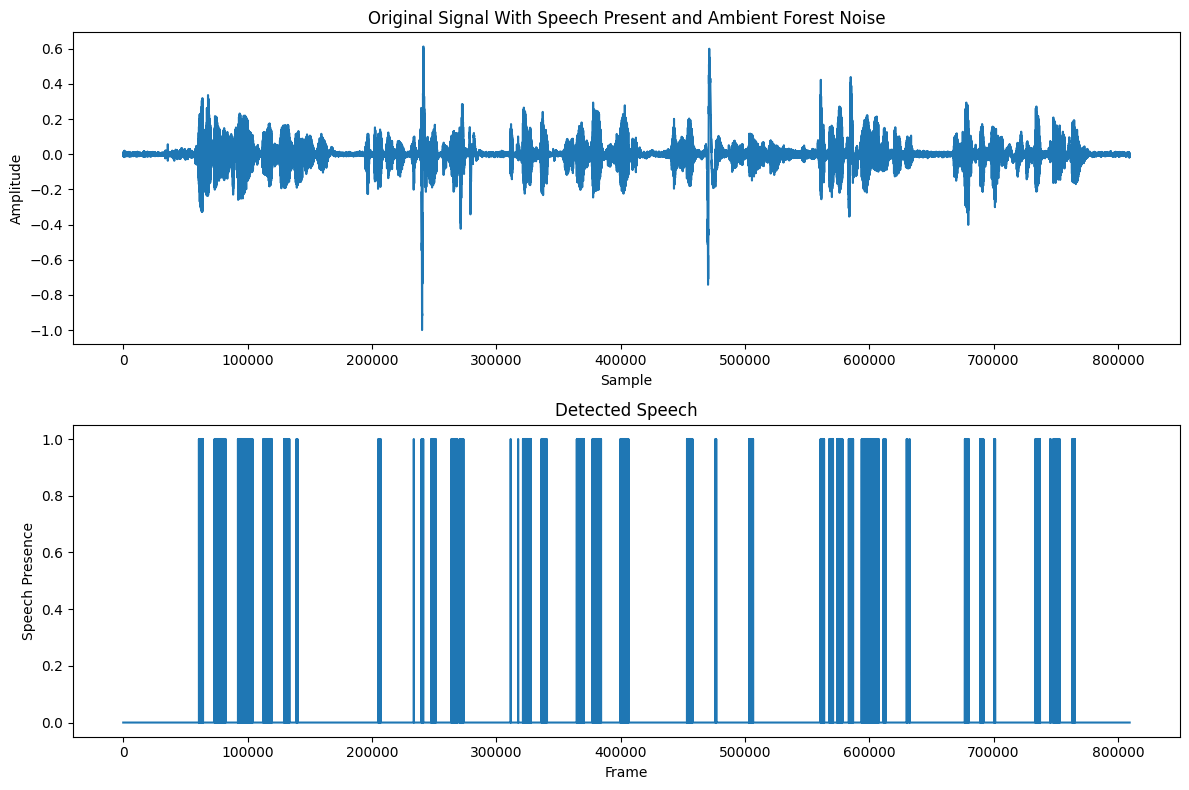

In [ ]:
# Visualization
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(mixedSignalF)
plt.title('Original Signal With Speech Present and Ambient Forest Noise')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(detectedSpeech)
plt.title('Detected Speech')
plt.xlabel('Frame')
plt.ylabel('Speech Presence')

plt.tight_layout()
plt.show()

## Spectrogram

<ipython-input-14-1c20a20d17a0>:39: RuntimeWarning: divide by zero encountered in log10
  ax3.pcolormesh(t3, f3, 10 * np.log10(Sxx3), shading='gouraud')
<ipython-input-14-1c20a20d17a0>:47: RuntimeWarning: divide by zero encountered in log10
  ax4.pcolormesh(t4, f4, 10 * np.log10(Sxx4), shading='gouraud')


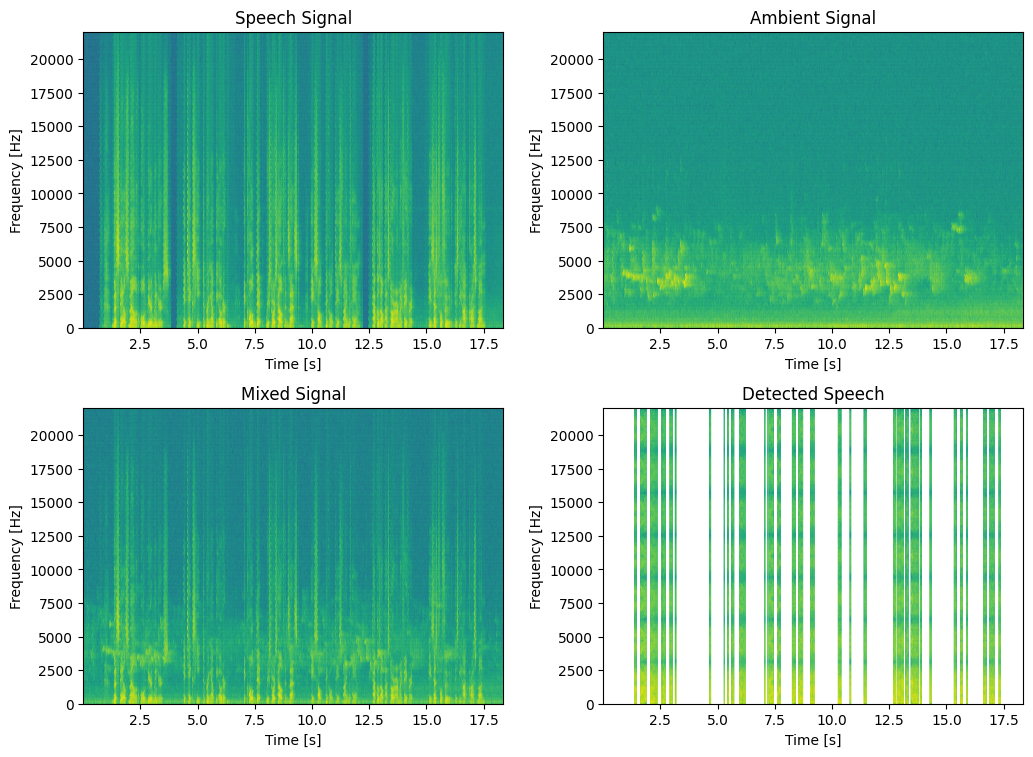

In [ ]:


# Define the parameters for the spectrogram
window = hamming(256, sym=False)
noverlap = 128
nfft = 512

audioSignal3 = mixedSignalF
audioSignal4 = detectedSpeech

# Create a figure with four subplots
fig = plt.figure(figsize=(10, 8))

# Subplot positions
left_margin = 0.07
bottom_margin = 0.1
subplot_width = 0.42
subplot_height = 0.37
horizontal_gap = 0.1
vertical_gap = 0.1

# First spectrogram: Speech Signal
ax1 = fig.add_axes([left_margin, bottom_margin + subplot_height + vertical_gap, subplot_width, subplot_height])
f1, t1, Sxx1 = spectrogram(audioSignal1, fs, window=window, noverlap=noverlap, nfft=nfft)
ax1.pcolormesh(t1, f1, 10 * np.log10(Sxx1), shading='gouraud')
ax1.set_title('Speech Signal')
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlabel('Time [s]')

# Second spectrogram: Ambient Signal
ax2 = fig.add_axes([left_margin + subplot_width + horizontal_gap, bottom_margin + subplot_height + vertical_gap, subplot_width, subplot_height])
f2, t2, Sxx2 = spectrogram(audioSignal2, fs, window=window, noverlap=noverlap, nfft=nfft)
ax2.pcolormesh(t2, f2, 10 * np.log10(Sxx2), shading='gouraud')
ax2.set_title('Ambient Signal')
ax2.set_ylabel('Frequency [Hz]')
ax2.set_xlabel('Time [s]')

# Third spectrogram: Mixed Signal
ax3 = fig.add_axes([left_margin, bottom_margin, subplot_width, subplot_height])
f3, t3, Sxx3 = spectrogram(audioSignal3, fs, window=window, noverlap=noverlap, nfft=nfft)
ax3.pcolormesh(t3, f3, 10 * np.log10(Sxx3), shading='gouraud')
ax3.set_title('Mixed Signal')
ax3.set_ylabel('Frequency [Hz]')
ax3.set_xlabel('Time [s]')

# Fourth spectrogram: Detected Speech
ax4 = fig.add_axes([left_margin + subplot_width + horizontal_gap, bottom_margin, subplot_width, subplot_height])
f4, t4, Sxx4 = spectrogram(audioSignal4, fs, window=window, noverlap=noverlap, nfft=nfft)
ax4.pcolormesh(t4, f4, 10 * np.log10(Sxx4), shading='gouraud')
ax4.set_title('Detected Speech')
ax4.set_ylabel('Frequency [Hz]')
ax4.set_xlabel('Time [s]')

# Save the figure as a PNG file
plt.savefig('spectrograms.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()